In [1]:
#-----------------------------------------------------------3.1 线性回归-----------------------------------------------------------

In [1]:
#矢量化加速
%matplotlib inline
import math 
import time
from mxnet import np
from d2l import mxnet as d2l

In [2]:
n=10000
a=np.ones(n)
b=np.ones(n)

In [5]:
#定义计时器用于对运行时间进行测试,#@save标记保存到d2l软件包
class Timer: #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times=[]
        self.start()
    def start(self):
        """启动计时器"""
        self.tik=time.time()
    def stop(self):
        """停止计时器并将时间记录在列表"""
        self.times.append(time.time()-self.tik)
        return self.times[-1]
    def avg(self):
        """返回平均时间"""
        return sum(self.times)/len(self.times)
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [6]:
c=np.zeros(n)
timer=Timer()
for i in range(n): #用for循环对a,b按元素相加
    c[i]=a[i]+b[i]
f'{timer.stop():.5f} sec'

'3.75579 sec'

In [7]:
timer.start()
d=a+b #用+运算符对a,b按元素相加。矢量化代码通常能实现数量级的加速
f'{timer.stop():.5f} sec'

'0.00036 sec'

In [10]:
#正太分布与平方损失
def normal(x,mu,sigma): #此函数用于计算正态分布
    p=1/math.sqrt(2*math.pi*sigma**2)
    return p*np.exp(-0.5/sigma**2*(x-mu)**2)

In [ ]:
#报错运行失败
x=np.arange(-7,7,0.01)
params=[(0,1),(0,2),(3,1)]
d2l.plot(x,[normal(x,mu,sigma) for mu,sigma in params],xlabel='x',
        ylabel='p(x)',figsize=(4.5,2.5),
        legend=[f'mean {mu},std {sigma}' for mu,sigma in params])

In [ ]:
#-----------------------------------------------------------3.2 线性回归从零实现-----------------------------------------------------------

In [2]:
%matplotlib inline 
import random
from mxnet import autograd,np,npx
from d2l import mxnet as d2l
npx.set_np()

In [3]:
#生成数据集
def synthetic_data(w,b,num_examples): #@save
    """生成y=Xw+b噪声"""
    X=np.random.normal(0,1,(num_examples,len(w))) #从均值为0，方差为1的正态（高斯）分布中抽取随机数据作为样本。输出数据shape=(num_examples,len(w))
    y=np.dot(X,w)+b
    y+=np.random.normal(0,0.01,y.shape) #random.normal(0,0.01,y.shape)生成噪声 
    return X,y.reshape((-1,1)) #y.reshape((-1,1))将y数据集转换成1列。reshape((-1,1))参见https://blog.csdn.net/lxlong89940101/article/details/84314703

In [4]:
true_w=np.array([2,-3.4])
true_b=4.2
features,labels=synthetic_data(true_w,true_b,1000) #通过合成函数synthetic_data生成样本数据集
print('features:',features[0],'\nlabel:',labels[0]) #打印第一个样本数据

features: [2.2122064 1.1630787] 
label: [4.662078]


Text(0, 0.5, 'labels')

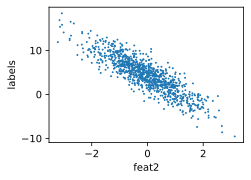

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].asnumpy(),labels.asnumpy(),1) #绘制第2个特征features[:,1]和labels的散点图
d2l.plt.gca().set_xlabel('feat2')
d2l.plt.gca().set_ylabel('labels')

In [6]:
#读取数据集
def data_iter(batch_size,features,labels): #打乱数据集样本，以小批量方式获取数据。输入：批量大小、特征矩阵、标签向量，输出：batch_size的小批量数据
    num_examples=len(features)
    indices=list(range(num_examples))
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        batch_indices=np.array(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]

In [7]:
batch_size=10
for X,y in data_iter(batch_size,features,labels): #获取数据集的一个小批量样本batch_size=10并打印
    print(X,'\n',y)
    break

[[-1.2347414   1.5580711 ]
 [-0.82706374 -0.9708203 ]
 [ 0.0688189   0.29507908]
 [-0.4783042  -0.4040312 ]
 [ 0.28326857 -0.08424569]
 [ 0.8332984   1.8107505 ]
 [ 2.0431964  -0.97231627]
 [-1.1448301  -0.35326418]
 [ 0.357444   -0.8942581 ]
 [-0.13436878  0.5427114 ]] 
 [[-3.563298 ]
 [ 5.8395247]
 [ 3.3268824]
 [ 4.6390505]
 [ 5.039916 ]
 [-0.2817729]
 [11.580438 ]
 [ 3.102985 ]
 [ 7.9626417]
 [ 2.0848947]]


In [8]:
#初始化模型参数
w=np.random.normal(0,0.01,(2,1)) #从均值0、标准差0.01的正态分布中采取随机数来初始化权重
b=np.zeros(1) #初始化偏置为0
w.attach_grad()
b.attach_grad()

In [10]:
#定义输入输出模型
def linreg(X,w,b):
    """线性回归模型"""
    return np.dot(X,w)+b #np.dot(X,w)是向量，b是标量，广播机制，标量会被加到向量的每个元素上

#定义损失函数
def squared_loss(y_hat,y): #@save
    """均方损失"""
    return (y_hat-y.reshape(y_hat.shape))**2/2 #使用平方损失函数，需真实值y和预测值y_hat形状相同

def sgd(params,lr,batch_size): #@save
    """小批量随机梯度下降
       入参：模型参数集合，学习速率，批量大小
    """
    for param in params:
        param[:]=param-lr*param.grad/batch_size

In [11]:
lr=0.03 #设置学习率(超参数)
num_epochs=3 #设置迭代周期数(超参数)
net=linreg
loss=squared_loss
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        with autograd.record():
            l=loss(net(X,w,b),y) #X和y的小批量损失
        l.backward()
        sgd([w,b],lr,batch_size) #使用参数的梯度更新参数
    train_l=loss(net(features,w,b),labels)
    print(f'epoch{epoch+1},loss{float(train_l.mean()):f}')

epoch1,loss0.024999
epoch2,loss0.000089
epoch3,loss0.000051


In [12]:
#比较模型参数w、b的真实值与预测值误差
print(f'w的估计误差：{true_w-w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b-b}')

w的估计误差：[ 5.0902367e-05 -3.8552284e-04]
b的估计误差：[0.00064135]


In [ ]:
#-----------------------------------------------------------3.3 线性回归简洁实现-----------------------------------------------------------
#使用深度学习框架实现线性回归模型

In [22]:
#生成数据集
from mxnet import autograd,gluon,np,npx
from d2l import mxnet as d2l
npx.set_np()
true_w=np.array([2,-3.4])
true_b=4.2
features,labels=d2l.synthetic_data(true_w,true_b,1000)  #调用函数synthetic_data()生成样本数据集

In [23]:
#读取数据集:调用框架中现有API实现读取数据
def load_array(data_arrays,batch_size,is_train=True): #@save
    """构造一个gluon数据迭代器"""
    dataset=gluon.data.ArrayDataset(*data_arrays)
    return gluon.data.DataLoader(dataset,batch_size,shuffle=is_train)

batch_size=10
data_iter=load_array((features,labels),batch_size)

In [24]:
next(iter(data_iter)) #使用iter构造python迭代器，使用next从迭代器中获取第一项

[array([[-0.38425833,  0.47222173],
        [ 0.77757806,  0.33856368],
        [-2.6620834 ,  0.9318762 ],
        [ 1.5791246 , -0.4863446 ],
        [-0.18378842,  0.04715518],
        [ 0.5227763 , -2.8541172 ],
        [-0.26062506, -1.3894261 ],
        [-1.8448477 ,  0.14837232],
        [ 0.9522357 , -0.12702385],
        [-0.26442173,  0.15424688]]),
 array([[ 1.8237417e+00],
        [ 4.5826893e+00],
        [-4.2956433e+00],
        [ 9.0161991e+00],
        [ 3.6715271e+00],
        [ 1.4940815e+01],
        [ 8.3941793e+00],
        [-7.9241320e-03],
        [ 6.5299430e+00],
        [ 3.1416216e+00]])]

In [25]:
#定义模型：使用框架预定义好的层
from mxnet.gluon import nn
net=nn.Sequential()
net.add(nn.Dense(1))

In [27]:
#初始化模型参数：深度学习框架通常有预定义初始化参数的方法
from mxnet import init #init为模块initializer快捷访问方式，initializer模块提供了各种模型参数初始化方法
net.initialize(init.Normal(sigma=0.01))

In [28]:
#定义损失函数
loss=gluon.loss.L2Loss() #Gluon中的loss模块定义了各种损失函数，在此使用均方误差

In [30]:
#定义优化算法：使用gluon提供的随机小批量梯度下降算法Trainer
from mxnet import gluon
trainer=gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':0.03}) #collect_params：从模型中获取优化参数；sgd：优化算法；最后需要给出优化算法所需要的超参数字典

In [31]:
#训练
num_epochs=3
for epoch in range(num_epochs):
    for X,y in data_iter:
        with autograd.record():
            l=loss(net(X),y)
        l.backward()
        trainer.step(batch_size)
    l=loss(net(features),labels)
    print(f'epoch{epoch+1},loss{l.mean().asnumpy():f}')

epoch1,loss0.036614
epoch2,loss0.000129
epoch3,loss0.000050


In [32]:
w=net[0].weight.data()
print(f'w的估计误差：{true_w-w.reshape(true_w.shape)}')
b=net[0].bias.data()
print(f'b的估计误差：{true_b-b}')

w的估计误差：[-0.00010896 -0.00049376]
b的估计误差：[-0.00030518]


In [ ]:
#-----------------------------------------------------------3.4 softmax回归-----------------------------------------------------------
